In [130]:
import pandas as pd
import os
from plotnine import ggplot, aes, geom_boxplot, geom_bar, stat_bin, xlim, ylim, ggtitle, geom_col, coord_flip
from scipy.stats import spearmanr
from sklearn.feature_extraction.text import TfidfVectorizer
from string import digits, punctuation


### 1.1 Загрузка данных

In [2]:
files = os.listdir('data/')

In [3]:
files[:5]

['reviews_argentina.csv',
 'reviews_lebanon.csv',
 'reviews_croatia.csv',
 'reviews_china.csv',
 'reviews_bosnia_and_herzegovina.csv']

Прочитаем все файлы в единый датафрейм:

In [9]:
df = pd.concat([pd.read_csv('data/'+file, sep = ';') for file in files], ignore_index=True)

In [10]:
df

,entry_id,country,description,designation,points,price,province,region,taster_name,title,variety,winery
0,119966,Argentina,Raspberry and cassis aromas are fresh and upri...,Pedernal,90,43.0,Other,San Juan,Michael Schachner,Finca Las Moras 2010 Pedernal Malbec (San Juan),Malbec,Finca Las Moras
1,119956,Argentina,Compared to the regular 2006 Malbec from Chaka...,Reserve,91,25.0,Mendoza Province,Luján de Cuyo,Michаеl Schаchnеr,Chakana 2006 Reserve Malbec (Luján de Cuyo),Malbec,Chakana
2,119950,Argentina,Andeluna's top wines tend to be ripe and plump...,Pasionado,91,55.0,Mendoza Province,Uco Valley,Michael Schachner,Andeluna 2004 Pasionado Red (Uco Valley),Red Blend,Andeluna
3,119943,Argentina,"A lively, well-made blend of Tempranillo, Malb...",B Crux,91,24.0,Mendoza Province,Uco Valley,Michаel Schаchner,O. Fournier 2005 B Crux Red (Uco Valley),Red Blend,O. Fournier
4,119939,Argentina,There is a select group of under-$20 Malbecs f...,La Madras Vineyard,91,18.0,Mendoza Province,Mendoza,Michаеl Schаchnеr,Ricardo Santos 2006 La Madras Vineyard Malbec ...,Malbec,Ricardo Santos
...,...,...,...,...,...,...,...,...,...,...,...,...
149903,31,France,Red cherry fruit comes laced with light tannin...,Nouveau,86,NaN,Beaujolais,Beaujolais-Villages,Rоger Vоss,Domaine de la Madone 2012 Nouveau (Beaujolais...,Gamay,Domaine de la Madone
149904,12,France,"This is a dry wine, very spicy, with a tight, ...",NaN,87,30.0,Alsace,Alsace,Roger Voss,Leon Beyer 2012 Gewurztraminer (Alsace),Gewürztraminer,Leon Beyer
149905,10,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam
149906,8,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,Roger Voss,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach


Проверим информацию о количестве пропущенных значений:

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149908 entries, 0 to 149907
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   entry_id     149908 non-null  int64  
 1   country      149908 non-null  object 
 2   description  149908 non-null  object 
 3   designation  106749 non-null  object 
 4   points       149908 non-null  int64  
 5   price        139418 non-null  float64
 6   province     149908 non-null  object 
 7   region       125516 non-null  object 
 8   taster_name  118829 non-null  object 
 9   title        149908 non-null  object 
 10  variety      149906 non-null  object 
 11  winery       149908 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 13.7+ MB


### 1.2 Очистка данных

Проверим, сколько у нас уникальных id и уникальных описаний:

In [13]:
df.duplicated('description').sum()

30012

In [14]:
df.duplicated('entry_id').sum()

29979

In [9]:
df.duplicated().sum()

15847

Избавимся от кирилических букв в именах дегустаторов:

In [16]:
df['taster_name'] = df['taster_name'].apply(lambda x: str(x).translate(str.maketrans('аео', 'aeo')))

In [17]:
df.duplicated().sum()

29979

In [18]:
df.duplicated('entry_id').sum()

29979

Количество дупликатов по id совпадает с количеством дупликатов по всем значениям, значит, все id уникальны.

Теперь удалим дупликаты:

In [19]:
df = df.drop_duplicates()

In [20]:
df

,entry_id,country,description,designation,points,price,province,region,taster_name,title,variety,winery
0,119966,Argentina,Raspberry and cassis aromas are fresh and upri...,Pedernal,90,43.0,Other,San Juan,Michael Schachner,Finca Las Moras 2010 Pedernal Malbec (San Juan),Malbec,Finca Las Moras
1,119956,Argentina,Compared to the regular 2006 Malbec from Chaka...,Reserve,91,25.0,Mendoza Province,Luján de Cuyo,Michael Schachner,Chakana 2006 Reserve Malbec (Luján de Cuyo),Malbec,Chakana
2,119950,Argentina,Andeluna's top wines tend to be ripe and plump...,Pasionado,91,55.0,Mendoza Province,Uco Valley,Michael Schachner,Andeluna 2004 Pasionado Red (Uco Valley),Red Blend,Andeluna
3,119943,Argentina,"A lively, well-made blend of Tempranillo, Malb...",B Crux,91,24.0,Mendoza Province,Uco Valley,Michael Schachner,O. Fournier 2005 B Crux Red (Uco Valley),Red Blend,O. Fournier
4,119939,Argentina,There is a select group of under-$20 Malbecs f...,La Madras Vineyard,91,18.0,Mendoza Province,Mendoza,Michael Schachner,Ricardo Santos 2006 La Madras Vineyard Malbec ...,Malbec,Ricardo Santos
...,...,...,...,...,...,...,...,...,...,...,...,...
149902,43,France,"This is a festive wine, with soft, ripe fruit ...",Nouveau,86,9.0,Beaujolais,Beaujolais,Roger Voss,Henry Fessy 2012 Nouveau (Beaujolais),Gamay,Henry Fessy
149903,31,France,Red cherry fruit comes laced with light tannin...,Nouveau,86,NaN,Beaujolais,Beaujolais-Villages,Roger Voss,Domaine de la Madone 2012 Nouveau (Beaujolais...,Gamay,Domaine de la Madone
149904,12,France,"This is a dry wine, very spicy, with a tight, ...",NaN,87,30.0,Alsace,Alsace,Roger Voss,Leon Beyer 2012 Gewurztraminer (Alsace),Gewürztraminer,Leon Beyer
149905,10,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


Стоит отметить, что отзывы не являются уникальными. Очень малая часть отзывов (33 штуки) слово в слово совпадают, несмотря на то, что сделаны разными авторами. Ниже приведён пример:

In [66]:
df[df['description'] == 'In 2009 this single vineyard offering includes 11% Sémillon. It has wonderful texture, and a mix of light herbal flavors that run through a gamut from celery to lemongrass and up into tart citrus fruit. The acidity is generous but not searing; it penetrates but never overpowers. A quintessential food wine.']

,entry_id,country,description,designation,points,price,province,region,taster_name,title,variety,winery
6226,49851,Australia,In 2009 this single vineyard offering includes...,Noble Baron,90,50.0,South Australia,Barossa,Joe Czerwinski,Château Tanunda 2007 Noble Baron Cabernet Sauv...,Cabernet Sauvignon,Château Tanunda
46200,57238,US,In 2009 this single vineyard offering includes...,Horse Heaven Vineyard,90,15.0,Washington,Horse Heaven Hills,Paul Gregutt,Chateau Ste. Michelle 2009 Horse Heaven Vineya...,Sauvignon Blanc,Chateau Ste. Michelle


Посмотрим количество пропусков после удаления дупликатов:

In [21]:
df.isnull().sum()

entry_id           0
country            0
description        0
designation    34535
points             0
price           8391
province           0
region         19501
taster_name        0
title              0
variety            1
winery             0
dtype: int64

Топ-5 авторов по числу отзывов:

In [22]:
df['taster_name'].value_counts()[1:6]

taster_name
Roger Voss           23558
Michael Schachner    14039
Kerin O’Keefe         9697
Paul Gregutt          8867
Virginie Boone        8708
Name: count, dtype: int64

In [23]:
authors = ['Roger Voss','Michael Schachner','Kerin O’Keefe','Paul Gregutt','Virginie Boone']

Всего авторов 20:

In [82]:
len(df['taster_name'].unique())

20

### 1.3 Эксплораторный анализ

Для начала посчитаем характеристики (среднее, медиана, стандартное отклонение) для цены и оценки вина:

In [83]:
df['points'].mean()

88.44214493575366

In [84]:
df['points'].median()

88.0

In [85]:
df['points'].std()

3.0932746182685547

In [86]:
df['price'].mean()

35.6261094873496

In [87]:
df['price'].median()

25.0

In [88]:
df['price'].std()

42.11291028863017

Для того, чтобы посчитать корреляцию, отюросим все значения оценок для которых пропущены соответсвующие значения цены:

In [24]:
df_new = df.dropna(subset=['points','price'])

Так как переменная points измеряется по ранговой шкале, а price по интервальной, то будем вычислять коэффициент корреляции Спирмена:

In [25]:
spearmanr(df_new['points'], df_new['price'])

SpearmanrResult(correlation=0.6124750550158435, pvalue=0.0)

Видно, что корреляция действительно существует и является статистически значимой.

In [26]:
df_authors = pd.DataFrame()
for i in range(5):
    df_authors = pd.concat([df_authors, df[df.taster_name == authors[i]]])

Посмотрим вина из каких стран чаще оценивают топ-5 авторов по продуктивности:

In [27]:
df_authors.groupby('taster_name')['country'].value_counts()

taster_name        country     
Kerin O’Keefe      Italy            9697
Michael Schachner  Spain            6046
                   Chile            4049
                   Argentina        3542
                   Uruguay            98
                   Italy              76
                   US                 71
                   Mexico             63
                   Brazil             49
                   France             20
                   Peru               16
                   Portugal            9
Paul Gregutt       US               8666
                   Canada            159
                   France             34
                   Spain               4
                   Italy               4
Roger Voss         France          17150
                   Portugal         5223
                   Austria          1064
                   Italy              96
                   South Africa       22
                   US                  2
                   Greece

Видно, что Kerin O’Keefe специализируется на итальянском вине. Virginie Boone и Paul Gregutt, в основном, оценивают вина Северной Америки. Michael Schachner преимущественно оценивает испанские, чилийские и аргентинские вина. Roger Voss специализируется на винах Франции и Португалии.

Выделим вина с рейтингом 90+:

In [28]:
df_90 = df[df.points >= 90]

Топ-10 виноградников по числу вин с рейтингом выше 90 баллов:

In [138]:
df_90.groupby(by=['country','winery'])['designation'].value_counts().sort_values()[-10:]

country  winery                 designation                
US       Lynmar                 Quail Hill Vineyard            14
         Chateau Ste. Michelle  Cold Creek Vineyard            14
         Jarvis                 Estate Grown Cave Fermented    15
         Tangent                Paragon Vineyard               15
         Williams Selyem        Allen Vineyard                 16
France   Joseph Cattin          Hatschbourg Grand Cru          16
US       Raymond                District Collection            17
France   Roche de Bellene       Vieilles Vignes                17
         Tardieu-Laurent        Vieilles Vignes                18
US       Novelty Hill           Stillwater Creek Vineyard      33
Name: count, dtype: int64

Векторизуем тексты описаний методом Tf-idf и посмотрим, какие есть маркеры отличного вина в описаниях:

In [139]:
words = list(df_90['description'].apply(lambda x: str(x).translate(x.maketrans('','',digits+punctuation))))

In [140]:
vectorizer = TfidfVectorizer(input='content', ngram_range=(2,3), stop_words='english', max_features=50)

In [141]:
X = vectorizer.fit_transform(words)

Получим список самых частотных и важных N-грамм из 2-3 слов без учёта предлогов, союзов и т.п.:

In [142]:
vectorizer.get_feature_names_out()

array(['age drink', 'age years', 'baking spice', 'berry fruits',
       'black cherry', 'black currant', 'black fruit', 'black fruits',
       'black pepper', 'black plum', 'blend cabernet',
       'blend cabernet sauvignon', 'bright acidity', 'cabernet franc',
       'cabernet sauvignon', 'cherry fruit', 'crisp acidity',
       'dark chocolate', 'finegrained tannins', 'finish drink',
       'firm tannins', 'french oak', 'fresh acidity', 'fruit flavors',
       'green apple', 'lingering finish', 'long finish',
       'merlot cabernet', 'nose palate', 'palate delivers',
       'palate offers', 'petit verdot', 'pinot noir', 'ready drink',
       'red berry', 'red cherry', 'red fruit', 'red fruits', 'rich wine',
       'ripe black', 'ripe fruit', 'stone fruit', 'structured wine',
       'tannins drink', 'white peach', 'white pepper', 'wine offers',
       'wine rich', 'wine shows', 'wood aging'], dtype=object)

На основании описаний вин с высоким (90+) рейтингом видно, что к маркерам отличного вина можно отнести возраст напитка, пряные нотки, нотки тёмных ягод (вишни, сливы, чёрной смородины), яркую кислинку, фруктовый аромат, долгое послевкусие, танины от выдержки в дубовой бочке, напоминающие по ощущениям тёмный шоколад. Среди вин с высоким рейтингом наиболее часто встречаются вина каберне совиньон, пети вердо, пино нуар, каберне фран, ассамбляж мерло и каберне.

### 1.4 Визуализация данных

Построим столбиковую гистограмму распределения для оценок вина:

/home/nikinho/miniforge3/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 99'. Pick better value with 'binwidth'.


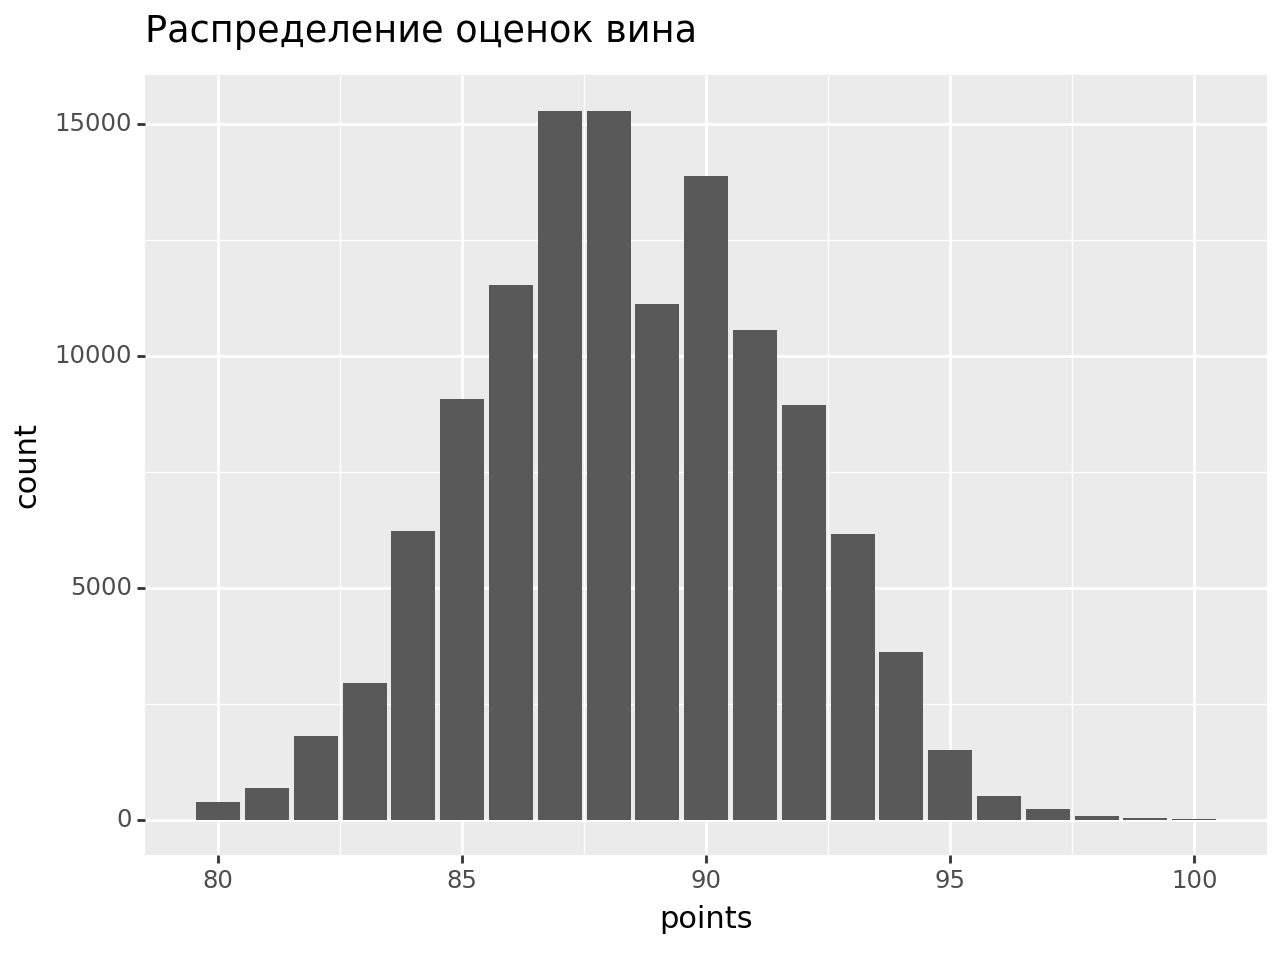

<Figure Size: (640 x 480)>

In [187]:
(
    ggplot(df)
    + aes(x='points')
    + stat_bin()
    + geom_bar()
    + ggtitle('Распределение оценок вина')

)

Видно, что оценки примерно распределены по нормальному закону.

Построим гистограмму для распределения цен:

/home/nikinho/miniforge3/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_bin : Removed 9056 rows containing non-finite values.
/home/nikinho/miniforge3/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_count : Removed 9056 rows containing non-finite values.
/home/nikinho/miniforge3/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.
/home/nikinho/miniforge3/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_bar : Removed 1 rows containing missing values.


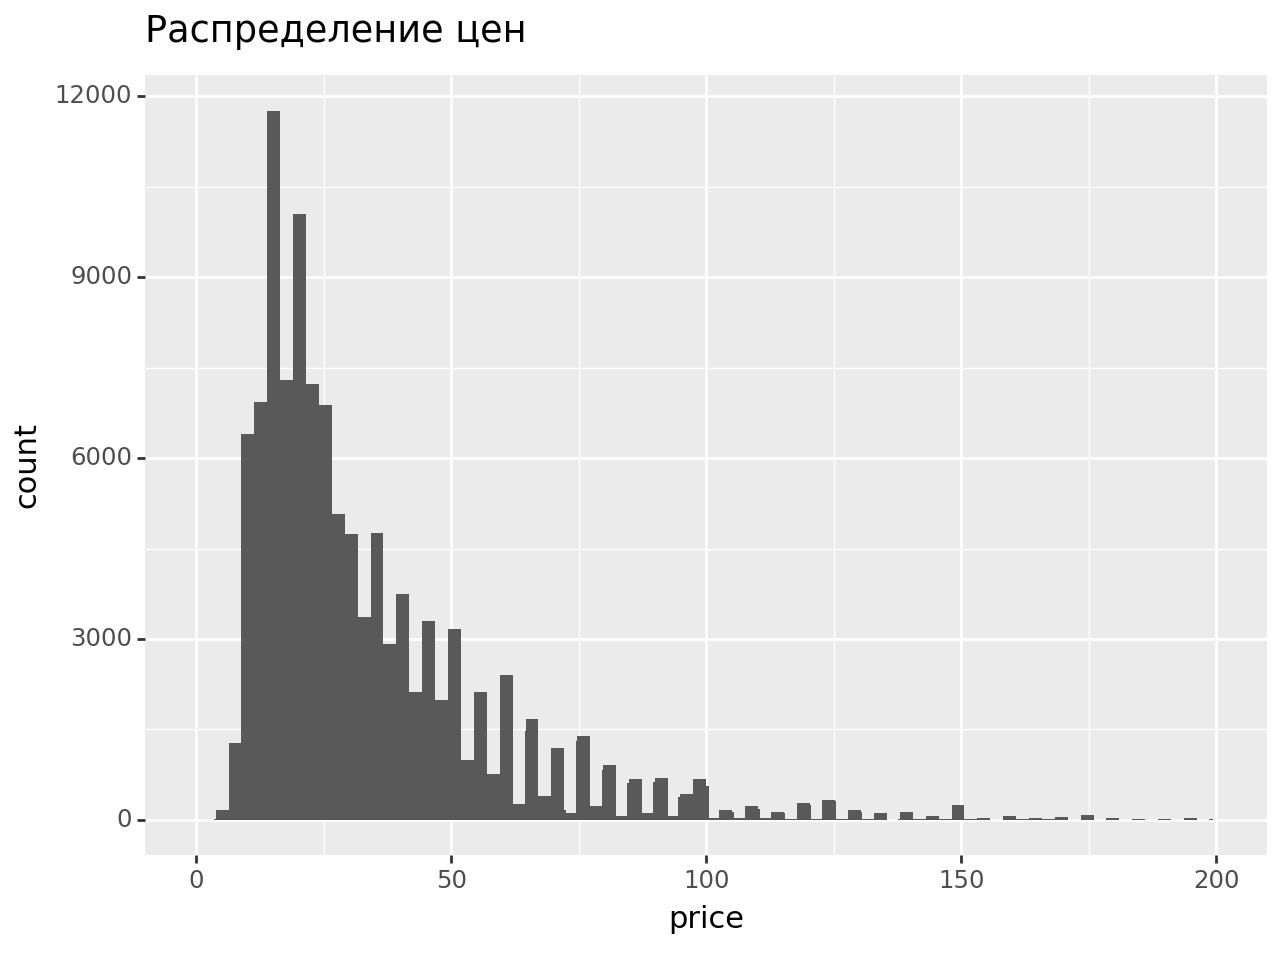

<Figure Size: (640 x 480)>

In [186]:
(
    ggplot(df)
    + aes(x='price')
    + stat_bin(bins=80)
    + geom_bar()
    + xlim(0,200)
    + ggtitle('Распределение цен')
)

"Иголки" на графике обусловлены тем, что чаще всего цены выбирают круглыми или кратными 5-10 долларам. Само распределение напоминает логнормальное.

Посмотрим связь цены и оценки вина:

/home/nikinho/miniforge3/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 665 rows containing non-finite values.


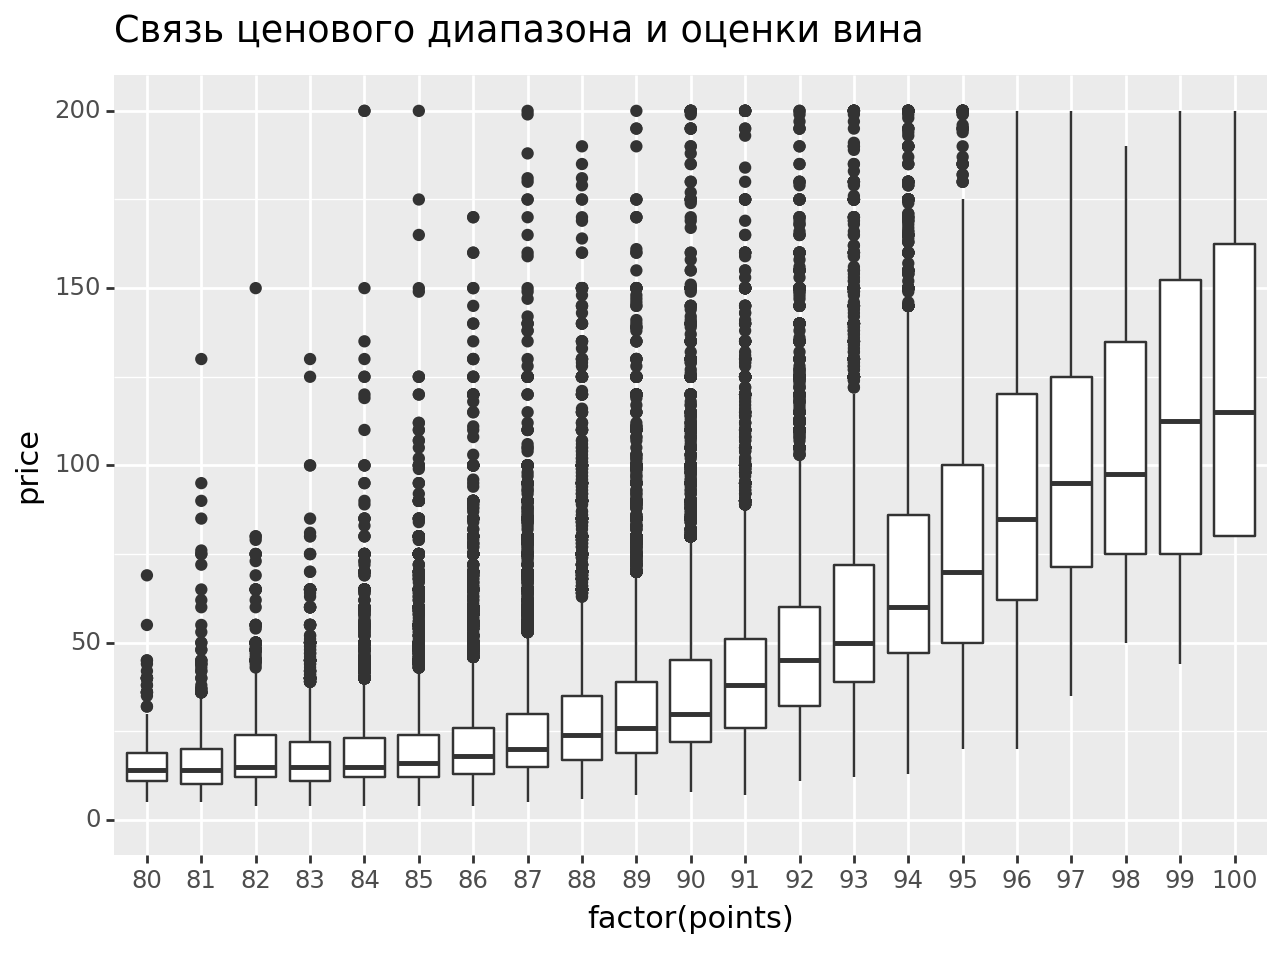

<Figure Size: (640 x 480)>

In [181]:
(
    ggplot(df_new)
    + aes(x='factor(points)', y='price')
    + geom_boxplot()
    + ylim(0, 200)
    + ggtitle('Связь ценового диапазона и оценки вина')


)

Хорошо видно, что среднее значение цены и диапазон цен действительно растут по мере роста рейтинга.

Посмотрим, отличаются ли ценовые диапазоны вин, оцениваемые топ-5 авторами:

/home/nikinho/miniforge3/lib/python3.10/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 6908 rows containing non-finite values.


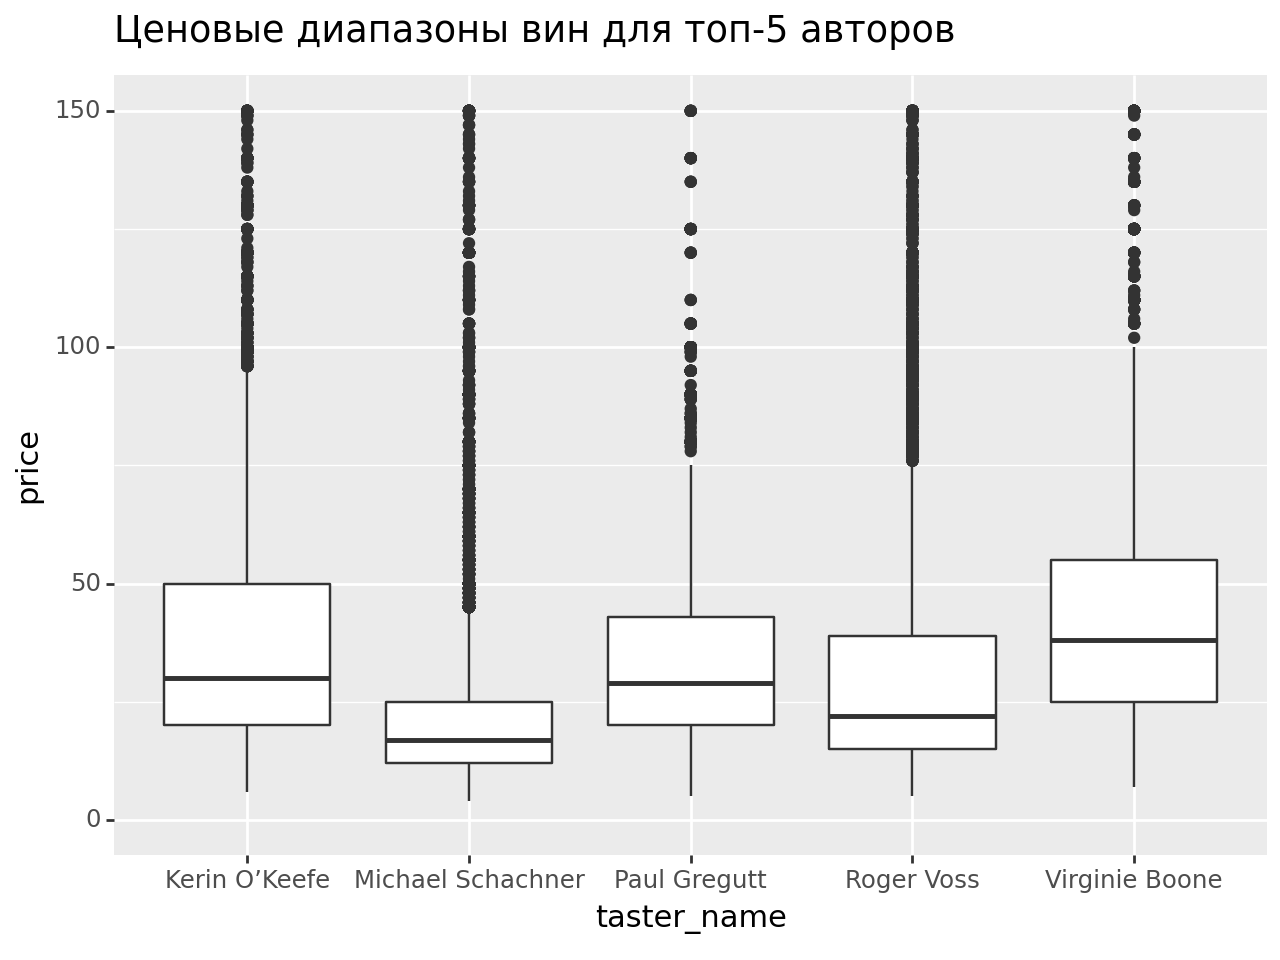

<Figure Size: (640 x 480)>

In [180]:
(
    ggplot(df_authors)
    + aes(x='taster_name', y='price')
    + geom_boxplot()
    + ylim(0, 150)
    + ggtitle('Ценовые диапазоны вин для топ-5 авторов')

)

Посмотрим, какие страны наиболее представлены среди вин с высоким рейтингом(90+):

In [48]:
countries = pd.DataFrame(df_90['country'].value_counts())

In [68]:
countries = countries.reset_index()

In [97]:
countries[:10]

,country,count
0,US,20735
1,France,8615
2,Italy,6191
3,Portugal,1889
4,Austria,1834
5,Spain,1467
6,Germany,1129
7,Australia,887
8,Argentina,714
9,Chile,612


In [107]:
countries_list = df_90['country'].value_counts().index.tolist()

In [108]:
cat = pd.Categorical(countries['country'], categories=countries_list)

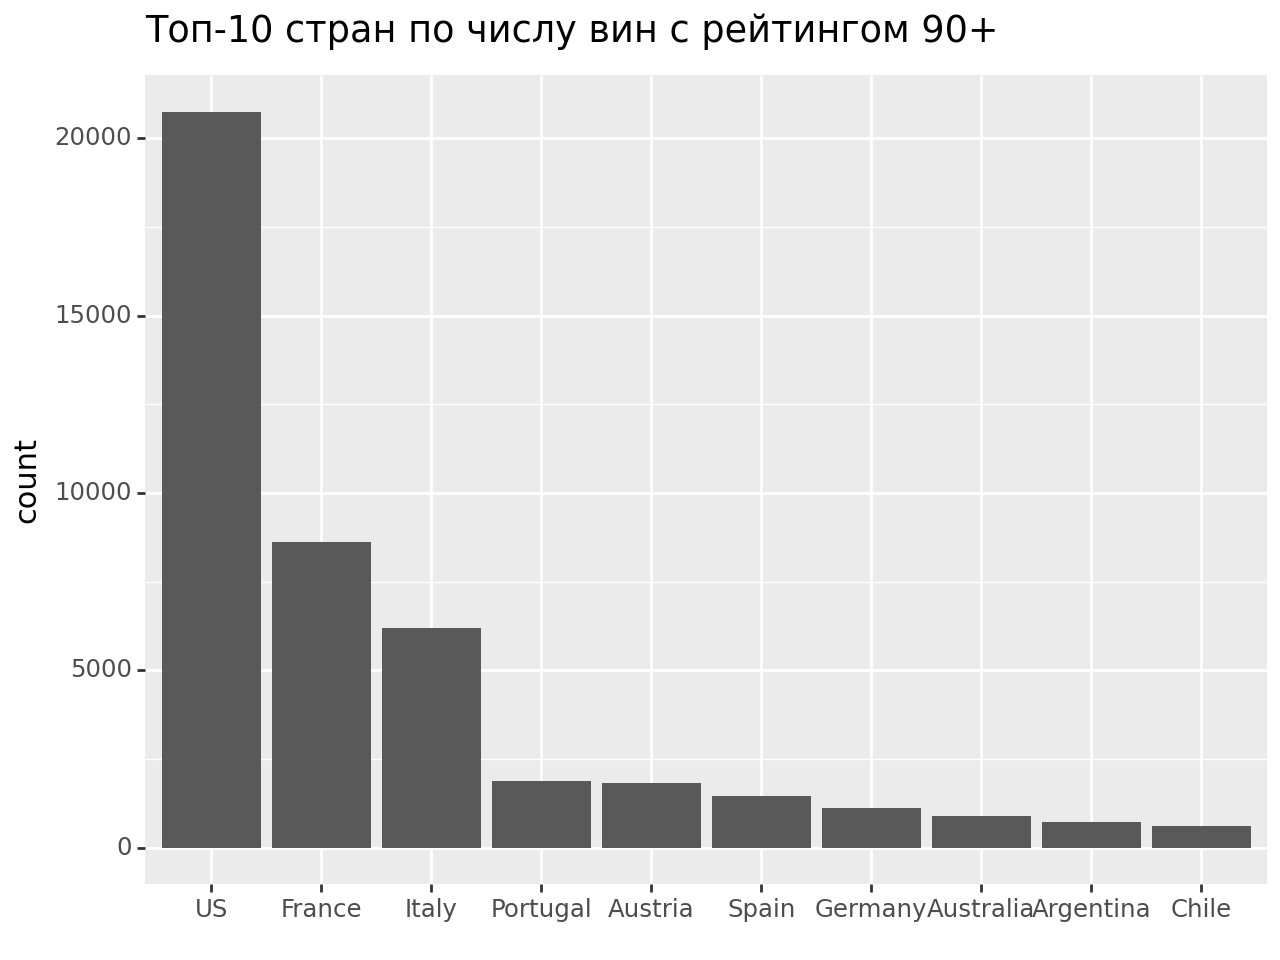

<Figure Size: (640 x 480)>

In [111]:
(
    ggplot(countries[:10])
    + aes(x=cat[:10], y='count')
    + geom_col()
    + ggtitle('Топ-10 стран по числу вин с рейтингом 90+')
)

Отдельно посмотрим, какие винодельни наиболее котируются критиками:

In [116]:
wineries = pd.DataFrame(df_90['winery'].value_counts()).reset_index()
wineries[:10]

,winery,count
0,Williams Selyem,176
1,Testarossa,143
2,Louis Latour,119
3,Lynmar,106
4,Gary Farrell,99
5,Foxen,80
6,Siduri,79
7,Dr. Loosen,78
8,Dutton-Goldfield,78
9,Domaine Zind-Humbrecht,77


In [127]:
wineries_list = df_90['winery'].value_counts().index.tolist()
winery_cat = pd.Categorical(wineries['winery'], categories=wineries_list)

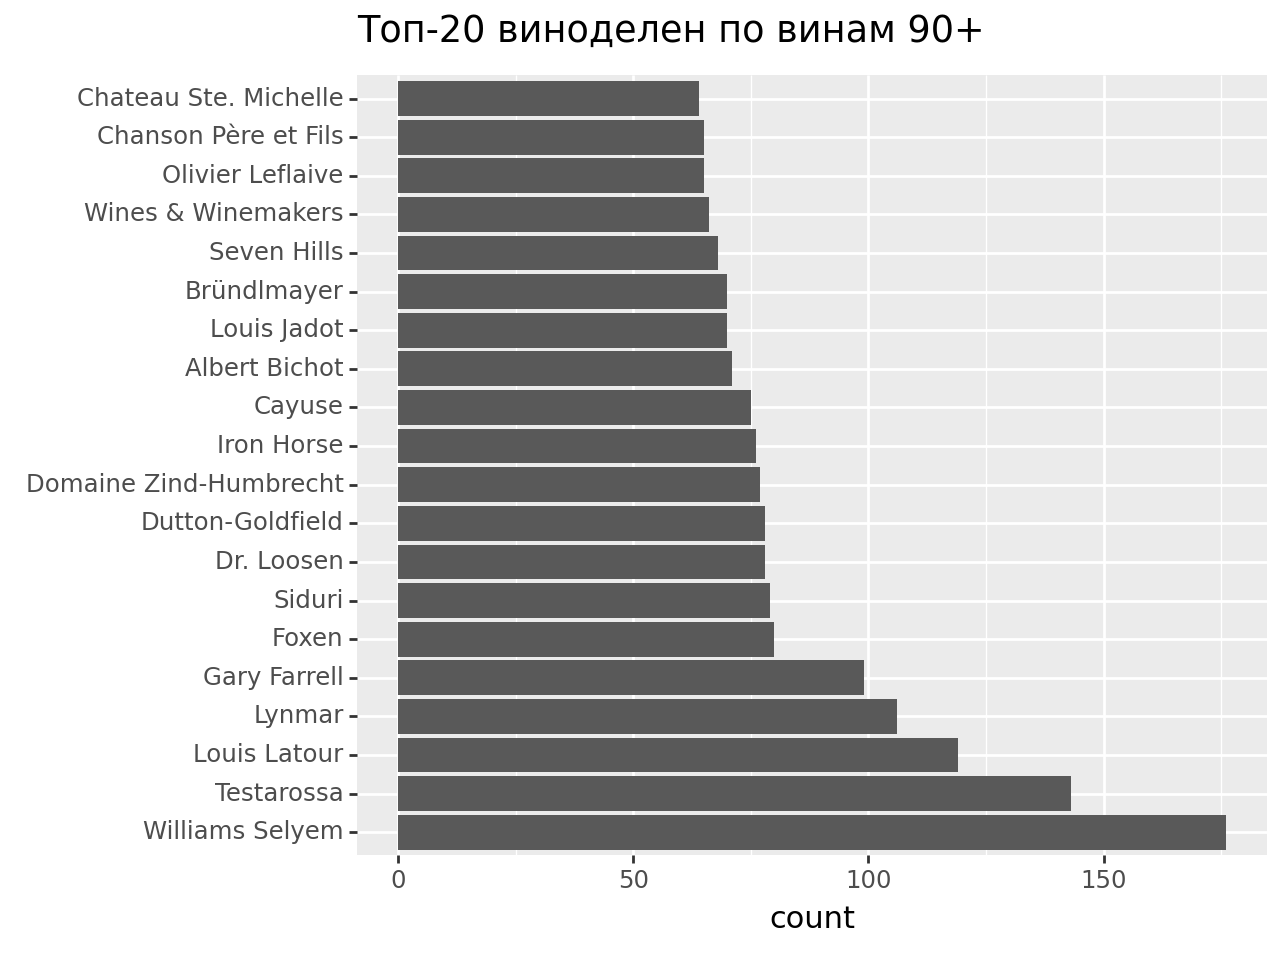

<Figure Size: (640 x 480)>

In [137]:
(
    ggplot(wineries[:20])
    + aes(x=winery_cat[:20], y='count')
    + geom_col()
    + coord_flip()
    + ggtitle('Топ-20 виноделен по винам 90+')
)